# Beer Classifier 
### Zach Sahlin Caleb Barker
### CPSC 322
The goal of this project is to be able to classify if any given beer will be good or not.  We got our data from data world and additionally used the google api to get the locations of the breweries.  Through this notbook we run multiple classifiers to try and figure out which one will be the best and We ended up finding that our decision tree was the best 

In [1]:
# some useful mysklearn package import statements and reloads
import importlib
import os
from matplotlib import pyplot as plt

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# uncomment once you paste your myclassifiers.py into mysklearn package
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import utils
importlib.reload(utils)
import utils as utils

In [2]:
fpath = os.path.join("Data", "beer_reviews_cleaned.csv")
table = MyPyTable().load_from_file(fpath)

## Data Analysis

### Beer Styles
We need to better understand the different values for the style of beer in order to make decisions on how to treat that attribute. If there are too many different styles, then we will need to combine similar styles. We will count the number of instances with each style and make a bar chart displaying the frequencies of each beer style.

First, we need to count the frequencies of each style. This can be done with the code.

In [3]:
styles = table.get_column("beer_style")

style_counts = {}
for style in styles:
    if style not in style_counts:
        style_counts[style] = 1
    else:
        style_counts[style] += 1


In [4]:
ratings = table.get_column("rating")

Now that the counts of all of the styles are stored in a dictionary, we can use matplotlib to create a bar chart using `plt.bar()`.

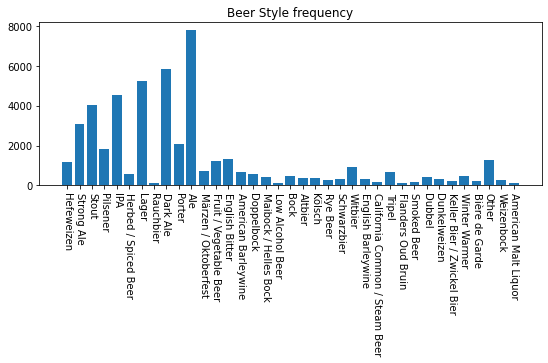

In [5]:
plt.figure(figsize=(9,3))
plt.bar(style_counts.keys(), style_counts.values())
plt.xticks(rotation= -90)
plt.title("Beer Style frequency")
plt.xlabel("")
plt.show()


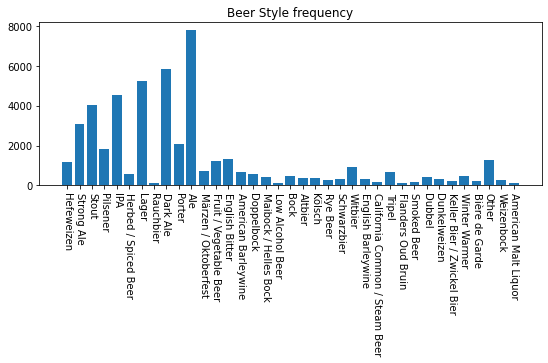

In [6]:
plt.figure(figsize=(9,3))
plt.bar(style_counts.keys(), style_counts.values())#,color = 'darkorange')
plt.xticks(rotation= -90)
plt.title("Beer Style frequency")
# plt.xticks(color='w')
# plt.yticks(color = 'w')
plt.xlabel("Rating of Beer")#,color='w')
#plt.savefig('Other/StyleFreq.png',dpi= 300,bbox_inches = 'tight')
plt.xlabel("")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

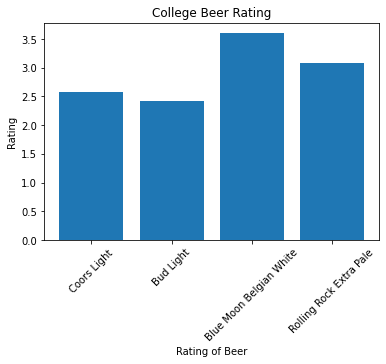

In [7]:
names = ["Coors Light","Bud Light","Blue Moon Belgian White","Rolling Rock Extra Pale"]
rating =[]
mt = MyPyTable()
mt.load_from_file("Data/joined_data_nums.csv")
for name in names:
    temp = mt.get_rows_with_val("beer_name",name)
    rating.append(temp.data[0][-4])
plt.bar(names,rating)#,color='darkorange')
plt.xticks(rotation= 45)
plt.ylabel("Rating")
# plt.xticks(color='w')
# plt.yticks(color = 'w')
plt.xlabel("Rating of Beer")#,color='w')
plt.title("College Beer Rating")#,color ='w')
#plt.savefig('Other/College.png',dpi= 300,bbox_inches = 'tight')
plt.show

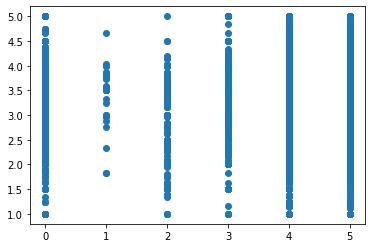

In [8]:
rating = []
brew_rating =[]
for col in mt.data:
    brew_rating.append(col [-2])
    rating.append(col[-4])
plt.scatter(brew_rating,rating)

plt.show()

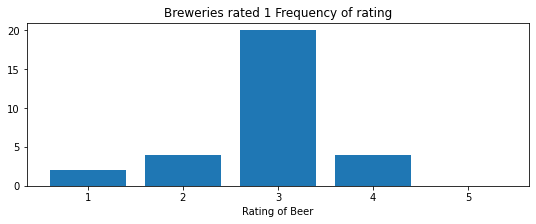

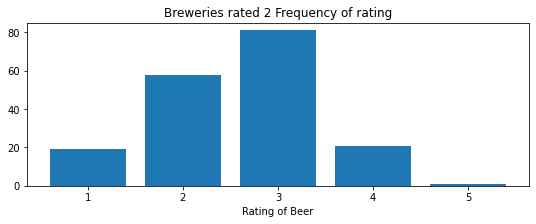

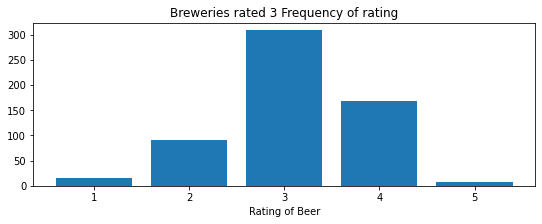

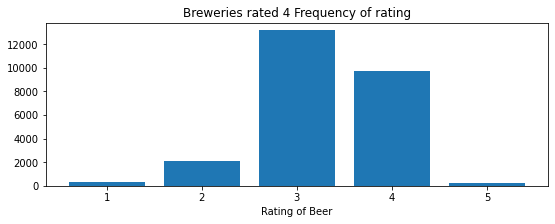

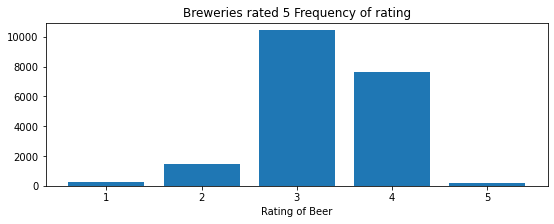

In [9]:
mt.load_from_file("Data/joined_data_ints.csv")
rating = []
brew_rating =[]
which_brews = [1,2,3,4,5]

for brew in which_brews:
    rating = []
    brew_rating =[]
    for col in mt.data:
        brew_rating.append(col [-2])
        rating.append(col[-4])
    other = [0,0,0,0,0]
    for i,val in enumerate(brew_rating):
        if val == brew:
            other[int(rating[i])-1] +=1
    xlabels = [1,2,3,4,5]
    plt.figure(figsize=(9,3))
    plt.bar(xlabels, other)#,color='darkorange')
    # plt.xticks(color='w')
    # plt.yticks(color = 'w')
    plt.title("Breweries rated " + str(brew) + " Frequency of rating")#,color ='w')
    #plt.savefig('Other/brewFreq'+ str(brew)+'.png',dpi= 300,bbox_inches = 'tight')
    plt.xlabel("Rating of Beer")#,color='w')
    
    plt.show()

In [10]:
hi = 0 
low =0
for val in table.data:
    if val[-1]  == "high":
        hi = hi + 1 
    else:
        low = low + 1 
print("Instances:",len(table.data))
print("Low Rating Instances",low, low/len(table.data))
print("High Rating Instances",hi , hi/len(table.data))



Instances: 49001
Low Rating Instances 25306 0.516438440031836
High Rating Instances 23695 0.4835615599681639


## Classification

We want to test to make sure that our data can be classified. We will do this by creating multiple classifiers and testing their performance over the dataset.

First, we need to split the data into X and y. Our y attribute, or class attribute, is the rating, because we are trying to predict the rating of a beer. First, we will try to use beer_style and beer_abv as the X attributes.


In [11]:
table = table.get_columns(['beer_style', 'beer_abv', 'rating'])
table.remove_rows_with_missing_values()

X = table.get_columns(['beer_style', 'beer_abv']).data
y = table.get_column('rating')


Next, we will use stratified k-fold cross validation to train and test our classifiers with a k value of 10. This will ensure that we are testing each instance of the dataset exactly once. We are making a dummy classifier, a Naive Bayes classifier, and a decision tree classifier. We are not using a kNN classifier because the dataset is very large and it takes too long. 

In [14]:
X_train_folds, X_test_folds = myevaluation.stratified_kfold_cross_validation(X, y, 1, random_state=0, shuffle=True)

dummy_y_pred = []
knn_y_pred = []
nb_y_pred = []
dt_y_pred = []
rf_y_pred = []
y_true = []
for fold in range(len(X_train_folds)):
    X_train = [X[index] for index in X_train_folds[fold]]
    y_train = [y[index] for index in X_train_folds[fold]]
    X_test = [X[index] for index in X_test_folds[fold]]
    y_test = [y[index] for index in X_test_folds[fold]]

    dummy_clf = MyDummyClassifier()
    dummy_clf.fit(X_train, y_train)
    dummy_y_pred.extend(dummy_clf.predict(X_test))

    # knn_clf = MyKNeighborsClassifier(5)
    # knn_clf.fit(X_train, y_train)
    # knn_y_pred.extend(knn_clf.predict(X_test))

    nb_clf = MyNaiveBayesClassifier()
    nb_clf.fit(X_train, y_train)
    nb_y_pred.extend(nb_clf.predict(X_test))

    dt_clf = MyDecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)
    dt_y_pred.extend(dt_clf.predict(X_test))

    rf_clf = MyRandomForestClassifier(4, 10, 2)
    rf_clf.fit(X_train, y_train)
    rf_y_pred.extend(rf_clf.predict(X_test))

    y_true.extend(y_test)

ValueError: high <= 0

In [ ]:
labels = ["high", "low"]
pos_label = "high"

utils.measure_performance(y_true, dummy_y_pred, labels, pos_label, "Dummy")

Dummy Perfomance:
Accuracy: 0.5155636452879581
Error rate: 0.48443635471204194
Precision: 0.0
Recall: 0.0
F1 measure: 0.0
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high       0  23687    23687                0
low        0  25209    25209              100


In [ ]:
# utils.measure_performance(y_true, knn_y_pred, labels, pos_label, "KNN")


Saved KNN results from when it ran earlier
![KNN](other/KNN%20Performance.png)

In [ ]:
utils.measure_performance(y_true, nb_y_pred, labels, pos_label, "Naive Bayes")

Naive Bayes Perfomance:
Accuracy: 0.5994559882198953
Error rate: 0.4005440117801047
Precision: 0.5839198036006547
Recall: 0.6024823742981382
F1 measure: 0.5930558730026805
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high   14271   9416    23687               60
low    10169  15040    25209               60


In [ ]:
utils.measure_performance(y_true, dt_y_pred, labels, pos_label, "Decision Tree")

Decision Tree Perfomance:
Accuracy: 0.5892097513089005
Error rate: 0.4107902486910995
Precision: 0.5629127502707991
Recall: 0.68011989698991
F1 measure: 0.6159905173402669
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high   16110   7577    23687               68
low    12509  12700    25209               50


In [ ]:
utils.measure_performance(y_true, rf_y_pred, labels, pos_label, "Random Forest")

Random Forest Perfomance:
Accuracy: 0.5881258180628273
Error rate: 0.41187418193717273
Precision: 0.5612822992952881
Recall: 0.6859458774855406
F1 measure: 0.6173838700484469
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high   16248   7439    23687               69
low    12700  12509    25209               50


Using these attributes did not give us very good results. The decision tree had the highest accuracy with 76.3%, which is only marginally higher than the dummy classifier accuracy of 74.1%.

### Using More Attributes
Due to the poor results previously, we decided to collect more data to use. We used the Google Places API to get more data on the breweries. This is done in the file named `places_api.ipynb`. We were able to get address, price level, and rating of each brewery. This data has been combined into `joined_data.csv`.

First, we need to load in this new data.

In [ ]:
joined_path = os.path.join("Data", "joined_data.csv")
joined_table = MyPyTable().load_from_file(joined_path)

Next, we need to split the data into X and y. We will keep rating as our y attribute, but this time, we will use beer_style, beer_abv, brewery_rating, and brewery_country as the X attributes.

In [ ]:
joined_table = joined_table.get_columns(['beer_style', 'beer_abv', 'rating', 'brewery_country', 'brewery_rating'])
joined_table.remove_rows_with_missing_values()
print(joined_table.column_names)
X_2 = joined_table.get_columns(['beer_style', 'beer_abv', 'brewery_country','brewery_rating']).data
y_2 = joined_table.get_column('rating')

['beer_style', 'beer_abv', 'rating', 'brewery_country', 'brewery_rating']


In [ ]:
X_train_folds_2, X_test_folds_2 = myevaluation.stratified_kfold_cross_validation(X_2, y_2, 1, random_state=0, shuffle=True)

dummy_y_pred_2 = []
knn_y_pred_2 = []
nb_y_pred_2 = []
dt_y_pred_2 = []
rf_y_pred = []
y_true_2 = []
for fold in range(len(X_train_folds_2)):
    X_train = [X_2[index] for index in X_train_folds_2[fold]]
    y_train = [y_2[index] for index in X_train_folds_2[fold]]
    X_test = [X_2[index] for index in X_test_folds_2[fold]]
    y_test = [y_2[index] for index in X_test_folds_2[fold]]

    # dummy_clf = MyDummyClassifier()
    # dummy_clf.fit(X_train, y_train)
    # dummy_y_pred_2.extend(dummy_clf.predict(X_test))

    knn_clf = MyKNeighborsClassifier(5)
    knn_clf.fit(X_train, y_train)
    knn_y_pred_2.extend(knn_clf.predict(X_test))

    # nb_clf = MyNaiveBayesClassifier()
    # nb_clf.fit(X_train, y_train)
    # nb_y_pred_2.extend(nb_clf.predict(X_test))

    # dt_clf = MyDecisionTreeClassifier()
    # dt_clf.fit(X_train, y_train)
    # dt_y_pred_2.extend(dt_clf.predict(X_test))

    # rf_clf = MyRandomForestClassifier(4, 10, 2)
    # rf_clf.fit(X_train, y_train)
    # rf_y_pred.extend(rf_clf.predict(X_test))

    y_true_2.extend(y_test)

IndexError: list index out of range

In [ ]:
labels = ["high", "low"]
pos_label = "high"

utils.measure_performance(y_true_2, dummy_y_pred_2, labels, pos_label, "Dummy")

Dummy Perfomance:
Accuracy: 0.5059230436662343
Error rate: 0.4940769563337657
Precision: 0.0
Recall: 0.0
F1 measure: 0.0
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high       0  22856    22856                0
low        0  23404    23404              100


In [ ]:
# utils.measure_performance(y_true_2, knn_y_pred_2, labels, pos_label, "KNN")

In [ ]:
utils.measure_performance(y_true_2, nb_y_pred_2, labels, pos_label, "Naive Bayes")

Naive Bayes Perfomance:
Accuracy: 0.6091223519239083
Error rate: 0.3908776480760917
Precision: 0.5958942632170978
Recall: 0.6489761988099405
F1 measure: 0.6213035100946637
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high   14833   8023    22856               65
low    10059  13345    23404               57


In [ ]:
utils.measure_performance(y_true_2, dt_y_pred_2, labels, pos_label, "Decision Tree")

Decision Tree Perfomance:
Accuracy: 0.587094682230869
Error rate: 0.412905317769131
Precision: 0.5665756533456261
Recall: 0.6990724536226811
F1 measure: 0.6258887126153123
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high   15978   6878    22856               70
low    12223  11181    23404               48


In [ ]:
print(len(rf_y_pred))
print(len(y_true))
utils.measure_performance(y_true, rf_y_pred, labels, pos_label, "Random Forest")

46260
48896


IndexError: list index out of range